In [1]:
import pandas as pd
import numpy as np

import pickle
train = pd.read_csv('../input/til2020/TIL_NLP_train_dataset.csv', index_col='id')
test = pd.read_csv('../input/til2020/TIL_NLP_test_dataset.csv', index_col='id')

In [3]:
from fastai.text import *

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(0)

In [4]:
# Create databunch
comb = train.append(test) # Use combined df for lm
data = (TextList.from_df(comb, cols='word_representation')
                .split_by_rand_pct(0.1)
                .label_for_lm()  
                .databunch(bs=64))
data.show_batch()

idx,text
0,w27013 w272605 w287214 w15393 w217871 w751 xxunk w317227 w368487 w319927 w70969 xxbos w254516 w135431 w115724 w331534 w256214 w71240 w356796 w326106 w34893 w175250 w217578 w186076 w349078 xxunk w241910 xxbos w53495 w306061 w372126 w47982 w66980 w189406 w71392 w217871 w127234 w301260 w51947 w336335 w217871 xxunk w500123 w221983 w103141 w105773 w318673 w380347 w201668 xxbos w237465 w256553 w286461 w382662 w206066 w121255 w244532 w163007 w233699 w277040 w365489 w333968 w250138 xxbos w173317 w39222 w207614 w136665 w394246 w197783
1,w393987 w39222 w174897 w195317 w271715 w286461 w82341 w89538 w236725 w176355 w135431 w112319 w165609 w256214 w384021 w69002 w1867 w120979 w275199 w374393 w316866 w138576 w15393 w322219 w195317 w357832 w186076 w66980 w189105 xxbos w318673 xxunk w376233 w250138 w125056 w28453 w225739 w253354 w311583 w204762 w150363 w279437 w69206 w25638 w342007 xxbos w29880 w215152 w84933 w101837 w70856 w320917 w500056 xxunk w270233 w177420 w41327 w151648 w155034 w152735 w279541 w48576 w334524 w217871 w279522 w43233 w186076 w399290 w279437 w22966
2,w61795 w119162 w191798 w5 xxrep 4 0 7 xxbos w372212 w127707 w186076 w282945 w391575 w380881 w223408 w286596 w70969 xxunk w277040 w163007 xxbos w15521 w174795 w234517 w167791 w234517 w3561 w314686 w127064 w203588 w101681 w186076 w215791 w15393 w111248 w194870 w74442 w365738 w305814 w399845 w34893 w182976 w394873 w285701 w183524 w384021 w22890 w75397 xxbos w7718 w134434 w162196 w39222 w61795 w119162 w241910 w42169 w377964 w311583 w8 w322219 w244630 w338587 w121255 w193800 w36882 xxbos w195317 w87218
3,w39218 w303227 w234583 w85858 w221983 xxbos w350483 w356690 w318673 w186076 w151648 w34893 w111248 w135431 w112319 w165609 w327489 w250138 w42169 w237465 w356690 w186076 w151648 w34893 w10799 w77630 w319927 w362316 xxbos w194870 w236280 w256905 w207614 w172013 w169548 w195815 w256553 w37419 w218713 w286461 w89538 w126056 w351537 w173688 w384021 w323852 w111248 w386149 w276577 w94172 w388086 w267864 w123298 w378979 w335583 w66217 w207614 w194870 w189105 w384336 w236835 xxbos w373517 w347736 w162965 w34893 w39218 w223408 w158353 w200253
4,w247655 w270233 w77504 w186076 w382355 w84933 w121255 w193800 w63426 w339993 w120979 w8992 w197783 w193800 w120979 xxbos w186457 w373517 w294269 w209913 w24292 w224831 w195317 w127737 w34893 w111248 w89538 w500109 w368487 w213720 w1867 w120979 w312941 w5 xxrep 4 0 5 w165492 w380494 w241910 xxbos w256553 w182887 w183695 w219120 w280823 w221983 w186076 w240587 w217871 w207614 w287214 w188324 w241910 w186076 w240587 xxbos w194000 w382355 w7718 w247699 w282225 w188064 w236725 w238507 w197783 w193800 w36882 w155034


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


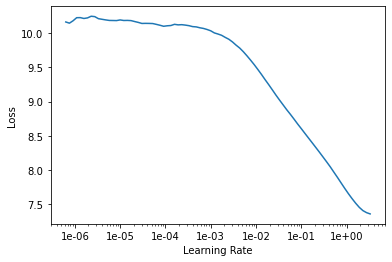

In [6]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

# select the appropriate learning rate
learn.lr_find()
learn.recorder.plot()

In [ ]:
#learn.save("zero")

In [7]:
#learn.load("zero")
learn.fit_one_cycle(13, 1e-2, moms=(0.8, 0.7))
# learn.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,time
0,8.580959,6.775153,0.053616,00:04
1,6.962227,5.793744,0.096027,00:04
2,5.977173,4.535324,0.238080,00:04
3,4.709247,3.223016,0.442500,00:04
4,3.741834,2.831375,0.491920,00:04
5,3.153942,2.659189,0.514196,00:04
6,2.783762,2.559010,0.523661,00:04
7,2.545020,2.495572,0.534286,00:04
8,2.382732,2.453712,0.537455,00:04
9,2.272664,2.427774,0.542991,00:04


In [ ]:
# learn.save_encoder('fine_tuned_enc')
# learn.save("lm")

In [8]:
learn.freeze_to(-3)
learn.fit_one_cycle(10, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))
# learn.save_encoder('fine_tuned_enc')

epoch,train_loss,valid_loss,accuracy,time
0,2.087714,2.404910,0.546250,00:04
1,2.077040,2.385739,0.548973,00:04
2,2.059541,2.368462,0.549911,00:04
3,2.034153,2.356258,0.552545,00:04
4,2.012651,2.344813,0.555357,00:04
5,1.989038,2.332805,0.556830,00:04
6,1.967157,2.328330,0.557143,00:04
7,1.954213,2.324639,0.558036,00:04
8,1.940594,2.323366,0.558170,00:04
9,1.935822,2.322374,0.558080,00:04


In [11]:
learn.save_encoder('fine_tuned_enc')

In [9]:
label_cols = ["outwear","top","trousers","women dresses","women skirts"]

test_datalist = TextList.from_df(test, cols='word_representation', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='word_representation', vocab=data.vocab)
             .split_by_rand_pct(0.1)
             .label_from_df(cols= label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
xxbos w173317 w39222 w207614 w93366 w230346 w323671 xxunk w137804 w279750 w500344 w294820 w33992 w66980 w392147 w373260 w322219 w245476 w52265 w217871 w296675 w207614 w34893 w113598 w338587 w267311 w186076 w222433 w34893 w341569 w204762 w101681 w175395 w115724 w266998 w171593 w36882 w384336 w311583 w89538 w236725 w66980 w384336 w192814 w193067 w311583 w241910 w113637,top;trousers
xxbos w173317 w39222 w207614 w553 w3068 w241910 w371725 w86889 w198528 w392147 w373260 w322219 w245476 w52265 w217871 w30555 w296675 w207614 w34893 w113598 w338587 w267311 w186076 w222433 w34893 w341569 w20780 w217871 w230090 w388086 w267864 w15393 w311583 w34893 w162756 w279437 w314686 w127064 w203588 w101681,outwear;trousers
xxbos w173317 w39222 w207614 w553 w7718 w378116 w201479 w99560 w234775 w71240 w66980 w392147 w373260 w322219 w245476 w52265 w217871 w30555 w296675 w207614 w34893 w113598 w338587 w267311 w186076 w34893 w341569 w332827 w323852 w311583 w339421 w34893 w89538 w149875 w217871 w345757 w386149 w6645 w202665 w15393,outwear;top
xxbos w119784 w194870 w125704 w31180 w131051 w126729 w269012 w90685 w195317 w53573 w253354 w186076 w41128 w373517 w294269 w78494 w238644 w174897 w240625 w189113 w165609 w500064 w267098 w276473 w12685 w105773 w194870 w279541 w261801 w253067 w311583 w314861 w286596 w3 xxrep 4 2 4 w15393,outwear;trousers
xxbos w173317 w39222 w207614 w314886 xxunk xxunk w305249 w75397 w127064 w203588 w12685 w66980 w392147 w373260 w322219 w245476 w52265 w217871 w30555 w296675 w207614 w113598 w338587 w267311 w186076 w222433 w34893 w341569 w115549 w213509 w26335 w277040 w305410 w392167 w34893 w89538 xxunk w133070 w241910,outwear;trousers


epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 2.09E-02


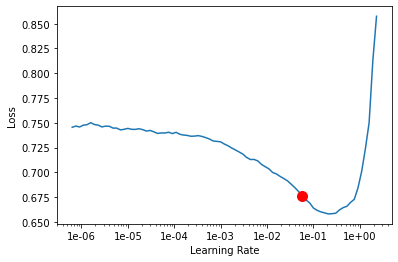

In [12]:
f_score = partial(fbeta, thresh=0.2)

learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=f_score)

# load the encoder saved  
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze()

# select the appropriate learning rate
learn_classifier.lr_find()

# we typically find the point where the slope is steepest
learn_classifier.recorder.plot(suggestion=True)

In [13]:
# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(10, 3e-2, moms=(0.8, 0.7))
learn_classifier.save('first')

epoch,train_loss,valid_loss,fbeta,time
0,0.516465,0.435251,0.817751,00:04
1,0.491913,0.435871,0.806509,00:03
2,0.487466,0.427342,0.816279,00:03
3,0.490860,0.417521,0.816634,00:03
4,0.473006,0.407541,0.831372,00:03
5,0.469357,0.400933,0.827268,00:03
6,0.463769,0.386982,0.836290,00:03
7,0.458824,0.384292,0.837612,00:03
8,0.441062,0.374947,0.840840,00:03
9,0.446857,0.374095,0.837670,00:03


In [14]:
learn_classifier.load('first')
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(10, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,fbeta,time
0,0.436681,0.360916,0.840893,00:03
1,0.403132,0.321828,0.850829,00:03
2,0.340491,0.206713,0.909888,00:04
3,0.254080,0.135767,0.939366,00:04
4,0.206290,0.103316,0.954717,00:04
5,0.184932,0.090376,0.956242,00:04
6,0.176114,0.078143,0.961792,00:04
7,0.153868,0.072737,0.967074,00:04
8,0.156474,0.072569,0.968149,00:04
9,0.156097,0.070945,0.966986,00:04


In [15]:
learn_classifier.save('second')

In [16]:
learn_classifier.load('second')
learn_classifier.fit_one_cycle(5, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,fbeta,time
0,0.150288,0.075058,0.965477,00:04
1,0.163536,0.080219,0.962923,00:04
2,0.148682,0.071357,0.968348,00:04
3,0.134553,0.062530,0.973909,00:04
4,0.131424,0.060947,0.972712,00:03


In [17]:
learn_classifier.save('second')

In [18]:
learn_classifier.load('second')
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(10, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,fbeta,time
0,0.122306,0.057277,0.974597,00:06
1,0.105891,0.053348,0.976764,00:05
2,0.087033,0.053909,0.977738,00:05
3,0.087893,0.050352,0.981952,00:06
4,0.085255,0.048217,0.981130,00:05
5,0.068457,0.045375,0.984985,00:05
6,0.055964,0.045095,0.983922,00:05
7,0.060168,0.043711,0.985667,00:06
8,0.046820,0.044740,0.985670,00:06
9,0.040805,0.044967,0.986016,00:06


In [19]:
learn_classifier.save('third')

In [23]:
learn_classifier.export(file = Path("/kaggle/working/export.pkl"))

In [25]:
newlearner = load_learner("/kaggle/working")

In [84]:
import pickle
from fastai.text import *

class get_clothes_class():
    def __init__(self, model_path, encoded_word_dict_path):
        self.classes = ["outwear", "top", "trousers", "women dresses", "women skirts"]
        ### Import model
        self.newlearn = load_learner(model_path, "export.pkl")
        ### Import decoding dictionary
        with open(encoded_word_dict_path, 'rb') as f:
            self.word_keys = pickle.load(f)
            f.close()
    
    '''plaintext to encoded words format'''
    def _encode_input(self, raw_string):
        raw_string_list = raw_string.split()
        encoded_string_list = [self.word_keys[i.lower()] for i in raw_string_list if i.lower() in self.word_keys.keys()]
        return ' '.join(encoded_string_list)    
    
    '''to process the encoded words for model prediction'''    
    def process_input(self, input_string):
        #detected_classes = []
        #for category in self.classes:
        #    if category in input_string:
        #        detected_classes.append(category)
        # Convert words into encoded input
        encoded_input_string = self._encode_input(input_string)
        print('encoded words: ', encoded_input_string)
        # Pass the processed input into the prediction
        result = self.newlearn.predict(encoded_input_string)[1].numpy()
        #Get classes result
        #detected_classes = []
        #for idx, category in enumerate(result):
        #    if category==1:
        #        detected_classes.append(self.classes[idx])
        detected_classes = [self.classes[idx] for idx, item in enumerate(result) if item==1]
        #detected_classes.append(detected_classes2)
        return detected_classes


In [85]:
### Example usage ###
clothes=get_clothes_class("/kaggle/working","../input/encoded-words/encoded_words.pkl")
result = clothes.process_input("i love my skirt as well as my trousers so much!")
print(result)

encoded words:  w374768 w14348 w43546 w221983 w93366 w45765 w93366 w43546 w70969 w287754
['trousers', ['trousers', 'women skirts']]


In [ ]:
outwear, top, trousers, women dresses, women skirts

In [33]:
preds = newlearner.predict('w173317 w39222 w207614 w553 w3068 w241910 w371725 w86889 w198528 w392147 w373260 w322219 w245476 w52265 w217871 w30555 w296675 w207614 w34893 w113598 w338587 w267311 w186076 w222433 w34893 w341569 w20780 w217871 w230090 w388086 w267864 w15393 w311583 w34893 w162756 w279437 w314686 w127064 w203588 w101681')[1]

In [38]:
results = preds.numpy()

In [39]:
print(results)

[1. 0. 1. 0. 0.]


In [40]:
results[0]

1.0

epoch,train_loss,valid_loss,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-05


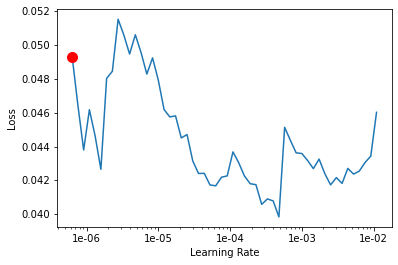

In [20]:
learn_classifier.load('third')
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.save('third_lr')

Build on

In [ ]:
from fastai.callbacks import *
# learn_classifier.load_encoder("fine_tuned_enc")
learn_classifier.callbacks = []
learn_classifier.freeze_to(-3)
learn_classifier.load('bestmodel')
learn_classifier.fit_one_cycle(10, slice(1e-6/(2.6**4), 1e-6), moms=(0.8, 0.7),
                               callbacks=[SaveModelCallback(learn_classifier, 'fbeta', name="fourth")])


In [ ]:
from fastai.callbacks import *
learn_classifier.fit_one_cycle(10, slice(1e-6/(2.6**4), 1e-6), moms=(0.8, 0.7),
                               callbacks=[SaveModelCallback(learn_classifier, 'fbeta', name="fourth")])

In [ ]:
learn_classifier.load("bestmodel")
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.load('bestmodel')
learn_classifier.fit_one_cycle(10, slice(3e-6/(2.6**4), 3e-6), moms=(0.8, 0.7),
                               callbacks=[SaveModelCallback(learn_classifier, 'fbeta', name="fourth")])

In [ ]:
learn_classifier.load('bestmodel')

In [ ]:
learn_classifier.load('third')
learn_classifier.freeze_to(-4)
learn_classifier.fit_one_cycle(5, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

In [ ]:
learn_classifier.fit_one_cycle(8, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

In [ ]:
learn_classifier.save('fourth')

In [ ]:
learn_classifier.load('bestmodel')
learn_classifier.show_results()

In [ ]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()

test_id = test['id']
submission = pd.DataFrame({'id': test_id})
submission = pd.concat([submission, pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1).round(0).astype(int)

submission.to_csv(root_dir+'submission.csv', index=False)
submission.head()

In [ ]:
'''
latest: acc: 0.983334, lm: 0.583705
bestmodel: acc: ~0.987, lm: 0.590402
fourth: acc: 0.9871498942375183, lm: 0.590402
'''